In [1]:
import pandas as pd

In [2]:
cryptos = pd.read_csv('crypto_data.csv')

In [3]:
cryptos.head()

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [12]:
traded = cryptos.loc[cryptos['IsTrading']].copy()

In [13]:
print(len(cryptos), len(traded))

1252 1144


In [14]:
traded.drop(columns=['IsTrading', 'CoinName', 'Unnamed: 0'], inplace=True)

In [15]:
traded.dropna(axis=0, how='any', inplace=True)

In [16]:
len(traded)

685

In [17]:
mined = traded.loc[traded['TotalCoinsMined'] > 0].copy()

In [18]:
len(mined)

532

In [26]:
mined.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,Scrypt,PoW/PoS,4.199995e+01,42
2,Scrypt,PoW/PoS,1.055185e+09,532000000
5,X13,PoW/PoS,2.927942e+10,314159265359
7,SHA-256,PoW,1.792718e+07,21000000
8,Ethash,PoW,1.076842e+08,0


In [27]:
mined.dtypes

Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply     object
dtype: object

In [32]:
mined['TotalCoinSupply'] = mined['TotalCoinSupply'].apply(lambda x: float(x))

In [34]:
ohencode = pd.get_dummies(mined, prefix=['algo', 'prooftype'])
len(ohencode.columns)

98

We went from 4 columns to almost 100. I happen to know that there were over 70 distinct values under the algorithm column. It is possible that we should have instead created an 'other' clump for all values that had only 1 instance of the algorithm in usage.

In [35]:
from sklearn.preprocessing import StandardScaler
mine_scaled = StandardScaler().fit_transform(ohencode)

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.9)
crypto_pca = pca.fit_transform(mine_scaled)

In [44]:
print(len(pca.explained_variance_ratio_))
(pca.explained_variance_ratio_)

74


array([0.0279317 , 0.02141802, 0.02051615, 0.02044661, 0.0204466 ,
       0.0204466 , 0.0204466 , 0.02042554, 0.01870913, 0.01756291,
       0.01741106, 0.01629007, 0.01596154, 0.01551138, 0.01435005,
       0.01321122, 0.01236583, 0.01206255, 0.01104295, 0.01071499,
       0.01049079, 0.01040887, 0.01039089, 0.01037741, 0.01035414,
       0.01034034, 0.01029605, 0.01028233, 0.01028139, 0.01028139,
       0.01028138, 0.01027965, 0.01027051, 0.01026331, 0.01026202,
       0.01025761, 0.01025565, 0.01025068, 0.01024924, 0.01024279,
       0.01024259, 0.01024259, 0.0102419 , 0.01024018, 0.01023676,
       0.01023495, 0.01023   , 0.01022442, 0.0102233 , 0.0102233 ,
       0.0102233 , 0.0102233 , 0.0102233 , 0.0102233 , 0.0102233 ,
       0.0102233 , 0.0102233 , 0.0102233 , 0.0102233 , 0.0102233 ,
       0.0102233 , 0.0102233 , 0.0102233 , 0.0102233 , 0.0102233 ,
       0.0102233 , 0.0102233 , 0.0102233 , 0.0102233 , 0.0102233 ,
       0.0102233 , 0.0102233 , 0.0102233 , 0.0102233 ])

We have only reduced our number of features by 20 in this case, which is still cause for some concern.

In [46]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate=35)
tsne_crypto = tsne.fit_transform(crypto_pca)
tsne_crypto.shape

(532, 2)

t-SNE has successfully reduced us to two features.

In [50]:
import matplotlib.pyplot as plt

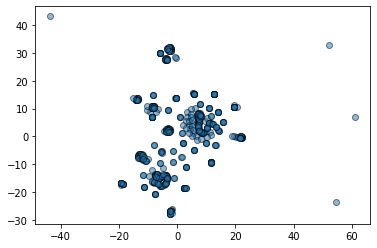

In [56]:
plt.scatter(tsne_crypto[:,0], tsne_crypto[:,1], alpha=0.5, edgecolors='black')

In [57]:
from sklearn.cluster import KMeans

C:\Users\Alexander Saunders\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


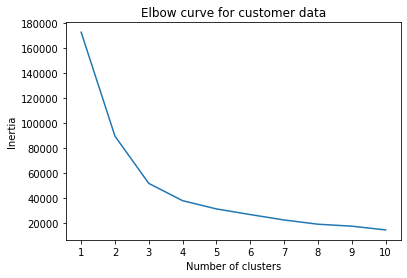

In [60]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(tsne_crypto)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for customer data')
plt.show()

There appears to be a strong elbow at 3, but a clearly defined elbow also occurs at 4. I will plot the scattered cryptocurrencies with a grouping of 4.

In [65]:
model = KMeans(4, random_state=42)
model.fit(tsne_crypto)
predictions= model.predict(tsne_crypto)
final_df = pd.DataFrame(data=tsne_crypto, columns=['comp1', 'comp2'])
final_df['class'] = model.labels_

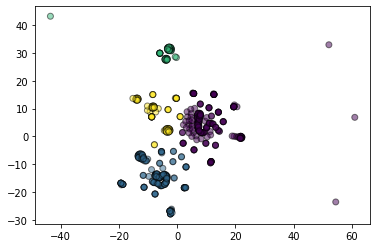

In [66]:
plt.scatter(final_df['comp1'], final_df['comp2'], c=final_df['class'], alpha=0.5, edgecolor='black')

The Cryptocurrencies can be grouped into 4 distinct clusters, which show visual differences when examined as well. There are at least 4 functional cryptocurrency groups - examining the differing behavior of these groups might lead to easier decisions when trying to create a cryptocurrency portfolio.